## Introduction
This notebook aims to replicate the studies that were successful in predicting the lattice constants of the Perovskite crystal ($ABO_{3}$). The papers preoduced the results with the model's error around 2%. It's important to identify the features neccessary to perform predictions. The lattice constants of the $ABO_{3}$ -type may be correlated compounds as a general function of nine variables as below

$Lattice constant = f(z_A + z_B + z_O + r_A + r_B + r_O + x_A + x_B + x_O)$

where z, r and x denote the valence, the radius and the electronegativity of the ions (A, B, O), respectively. It is noted that the three variables associated with anion $O^{2-}$ , namely $z_{O}, r_{O},$ and $x_{O}$ can be ignored as they remain unchanged for all of the samples.

The lattice constant can be reduced as a ﬁve-parameter function shown below.

$Lattice constant = f(z_A + r_A + r_B + x_A + x_B)$

The Goldschmidt’s tolerance factor (t) can condense the coation atomic radii into one expression. It has been widely accepted as a criterion for the formation of the perovskite structure, up to now. I will use $\textbf{four features}$ including the tolerance factor and others are denoted by, $r_{A}, r_{B}$ and $\frac{r_{A}}{t}$. The list of feature does not include electronegativity and valence number. Basically, other sets of features that includes these two atomic configurations can be used to predict the lattice constant with great accuracy. However, I will only take the atomic radii of the two cations in to my account. The tolerance factor (t) is expressed as below.

$t = \frac{r_A + r_O}{\sqrt{2}(r_B + r_O)}$

## Procedure
First I will perform feature engineering. Next I will build the ANN (Hereafter called as ANN) model and also perform a GridSearch (GS). GS fine tunes the hyperparameters of the ANN. Finally I will perform the predictions from the model. The model will be prepared with the fine tuned hyperparameters. The GridSearch in the sklearn package convineintly provides the best model which can be used to fit and predict.

## Feature engineering
In the following section, the ".csv" file is loaded into the program. The data is inspected for assurity. I observed the '.csv' provides the atomic radii for two atoms A and B in the crystal ($r_{A}$ and $r_{b}$), and the tolerance factor is absent. So the tolerance factor and $\frac{r_{A}}{t}$ needs to be calculated. I have concanated them as columns in the following code.

In [41]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd

lat_df = pd.read_csv('lat_const.csv', header=0, index_col = 0, usecols= ['compound','ra','rb','xa','xb','za','a','b','c'])
print ("The first five smaples from the DataFrame\n")
print (lat_df.head())

The first five smaples from the DataFrame

            ra    rb    xa    xb  za       a       b       c
compound                                                    
BaCeO3    1.35  0.87  0.89  1.12   2  6.2350  8.7810  6.2120
BaPrO3    1.35  0.85  0.89  1.13   2  6.2140  8.7220  6.1810
BaPuO3    1.35  0.86  0.89  1.30   2  6.1930  8.7440  6.2190
CaCrO3    1.00  0.55  1.00  1.66   2  5.3160  7.4860  5.2870
CaGeO3    1.00  0.53  1.00  2.01   2  5.2688  7.4452  5.2607


In [42]:
lat_df = lat_df.assign(tolerance = lambda x:((x['ra'] + 1.4)/(np.sqrt(2)*(x['rb'] + 1.4))))
lat_df = lat_df.assign(rat = lambda x:(x['ra']/x['tolerance']))

print ("The first five rows of imputed DataFrame\n")
print (lat_df.head())

features = np.array(lat_df[['ra', 'rb', 'tolerance', 'rat']], np.float32)
targets = np.array(lat_df[['a', 'b', 'c']], np.float32)


The first five rows of imputed DataFrame

            ra    rb    xa    xb  za       a       b       c  tolerance  \
compound                                                                  
BaCeO3    1.35  0.87  0.89  1.12   2  6.2350  8.7810  6.2120   0.856627   
BaPrO3    1.35  0.85  0.89  1.13   2  6.2140  8.7220  6.1810   0.864242   
BaPuO3    1.35  0.86  0.89  1.30   2  6.1930  8.7440  6.2190   0.860418   
CaCrO3    1.00  0.55  1.00  1.66   2  5.3160  7.4860  5.2870   0.870285   
CaGeO3    1.00  0.53  1.00  2.01   2  5.2688  7.4452  5.2607   0.879304   

               rat  
compound            
BaCeO3    1.575948  
BaPrO3    1.562063  
BaPuO3    1.569006  
CaCrO3    1.149049  
CaGeO3    1.137263  


In [43]:

print ("\nThe first five observations of the features")
print (features[:5,:])



The first five observations of the features
[[1.35       0.87       0.85662717 1.5759481 ]
 [1.35       0.85       0.8642416  1.5620632 ]
 [1.35       0.86       0.86041754 1.5690056 ]
 [1.         0.55       0.8702853  1.1490486 ]
 [1.         0.53       0.87930375 1.1372634 ]]


In [44]:
print ("\nThe first five observations of the targets")
print (targets[:5,:])


The first five observations of the targets
[[6.235  8.781  6.212 ]
 [6.214  8.722  6.181 ]
 [6.193  8.744  6.219 ]
 [5.316  7.486  5.287 ]
 [5.2688 7.4452 5.2607]]


### Normalization
Normalization (or min-max normalization) scale all values in a fixed range between 0 and 1. This transformation does not change the distribution of the feature and due to the decreased standard deviations, the effects of the outliers increases. Therefore, before normalization, it is recommended to handle the outliers.


In [45]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer()

scaler.fit(features)
features = scaler.transform(features)
print(features)

[[0.5607106  0.36134684 0.35579255 0.65455616]
 [0.56387436 0.35503203 0.3609805  0.65244997]
 [0.56229514 0.35820284 0.35837674 0.65351427]
 [0.54391146 0.29915133 0.47335815 0.6249807 ]
 [0.54656696 0.28968048 0.4805984  0.6215906 ]
 [0.54656696 0.28968048 0.4805984  0.6215906 ]
 [0.53398734 0.33107215 0.44861713 0.63560325]
 [0.5232715  0.3610573  0.42489052 0.644432  ]
 [0.5354591  0.32663006 0.45209166 0.63419986]
 [0.5397707  0.31306702 0.46263704 0.6297647 ]
 [0.51849306 0.373315   0.4150528  0.6477129 ]
 [0.524666   0.33689082 0.45657924 0.63463813]
 [0.53310525 0.3378093  0.44092375 0.638177  ]
 [0.38529196 0.5008795  0.50501543 0.58790237]
 [0.5230177  0.35047576 0.4407823  0.63978916]
 [0.5095158  0.36393985 0.44612792 0.63946176]
 [0.5095158  0.36393985 0.44612792 0.63946176]
 [0.5229058  0.3217882  0.47887594 0.627455  ]
 [0.5110687  0.3594329  0.44968116 0.63828176]
 [0.5048296  0.36869577 0.44804478 0.6391138 ]
 [0.50638986 0.36414552 0.45163262 0.6379618 ]
 [0.51860607 

## Machine Learning Model

The prediction of lattice constants for $ABO_{3}$ from the atomic configurations like radii and tolerance has enigmatic mechanism. A linear regression model can not be conceived to solve multiple target variables. It can be deployed only in the case of single target variable. Here, the artificial neural network comes to the rescue. ANNs performance is remarkable for regression model. ANN works for any kind of numerical system.

For the ANN, I will choose the loss function as the mean absolute error. "MAE" does not penalise the outliers in predictions compared to mean square error and huber loss function. I will choose Adam optimizer over Stochastic gradient descent (SGD). Besides Adam optimizer the other hyperparameters are number of neural nodes, number of hidden layers, learning rate (Adam optimizer), activation functions and so on. The ANN has lots of hyperparameters to be tuned before I set out to predict the target variables. So a GS will be neccessary to narrow down the optimal set of hyperparameters.

A quick run down to my model's parameter is below.
1. Number of epochs = 350
2. Train and test data split ratio = 80:20
3. Number of hidden layers = 2
4. Number of neurons in each hidden layer = 400

Once the model finishes its job, the loss (mean absolute error) and the graph for train and test loss against number of epochs is shown. Next, I will perform the GridSearch.

Epoch 1/650
3/3 [==============================] - 0s 48ms/step - loss: 6.1585 - val_loss: 6.0434
Epoch 2/650
3/3 [==============================] - 0s 10ms/step - loss: 5.9095 - val_loss: 5.7940
Epoch 3/650
3/3 [==============================] - 0s 11ms/step - loss: 5.6508 - val_loss: 5.5002
Epoch 4/650
3/3 [==============================] - 0s 11ms/step - loss: 5.3407 - val_loss: 5.1396
Epoch 5/650
3/3 [==============================] - 0s 11ms/step - loss: 4.9571 - val_loss: 4.6898
Epoch 6/650
3/3 [==============================] - 0s 11ms/step - loss: 4.4797 - val_loss: 4.1320
Epoch 7/650
3/3 [==============================] - 0s 11ms/step - loss: 3.8878 - val_loss: 3.4426
Epoch 8/650
3/3 [==============================] - 0s 12ms/step - loss: 3.1572 - val_loss: 2.5959
Epoch 9/650
3/3 [==============================] - 0s 11ms/step - loss: 2.2653 - val_loss: 1.7291
Epoch 10/650
3/3 [==============================] - 0s 11ms/step - loss: 1.5865 - val_loss: 1.3107
Epoch 11/650
3/3 [=

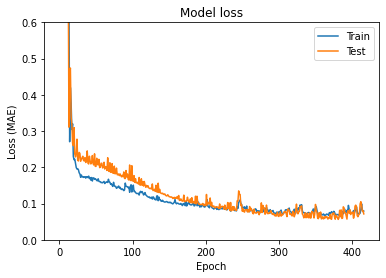


 The predicted values (Lattice constants)
[[6.207704  8.309064  5.780457 ]
 [5.72568   7.8735228 5.539663 ]
 [5.5966444 7.666996  5.3705606]
 [5.7735844 8.057046  5.724116 ]
 [5.6514635 7.7628736 5.4516163]
 [5.6368704 7.618869  5.2953415]
 [5.6018505 7.716814  5.4245634]
 [5.6453485 7.700329  5.383646 ]
 [6.4260883 7.9754753 5.2657013]
 [5.674617  7.773094  5.4514494]
 [5.6789827 7.830855  5.5149107]
 [6.170784  8.446334  5.95971  ]
 [5.371375  7.416997  5.2018557]
 [5.360969  7.357772  5.1398015]
 [5.815357  8.096269  5.7475486]
 [5.586218  7.5844216 5.2820663]
 [5.72568   7.8735228 5.539663 ]
 [6.1088285 8.505891  6.0622005]
 [5.638216  7.5960126 5.2683225]
 [5.5980673 7.679818  5.3844137]]

 The mean absolute error (MAE)
-0.07142883539199829


In [46]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from matplotlib import pyplot as plt

# The seed is required for replication of results. Parameters defined.
seed = 1234
tolerance_value = 35
n_epochs = 650

X_train, X_test, y_train, y_test = train_test_split(features, targets,
                                                    random_state=seed,
                                                    test_size=0.2)

def build_model(n_hidden=2, n_neurons=375, learning_rate=1e-3, input_shape=[features.shape[1],]):
    model = keras.Sequential()

    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", use_bias= False))
        # model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(targets.shape[1]))

    model.compile(loss="mae", optimizer=keras.optimizers.Adam(lr=learning_rate))

    return model

# The wrapper is neccessary for GridSearch later in this notebook
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# The history dictionary is useful for 'loss' plot of the model. In this case, the 'loss' is mean absolute error 
history = keras_reg.fit(X_train, y_train, epochs=n_epochs,
              validation_data=(X_test, y_test),
              callbacks=[keras.callbacks.EarlyStopping(patience=tolerance_value)])

# Test on the holdout data
mae_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_test)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss (MAE)")
plt.xlabel("Epoch")
plt.ylim(top=0.6, bottom = 0)
plt.legend(["Train", "Test"])
plt.show()


print ("\n The predicted values (Lattice constants)")
print (y_pred)
print ("\n The mean absolute error (MAE)")
print (mae_test)

## GridSearch
Grid search (GS) as the name suggests requires a grid made up by the hyperparamters. The alogorithm then runs the model over the grid and finds the best set of parameters for which the model perform best, i.e. low error (MSE, MAE, huber loss, etc in case of refression). The algorithm is heavy because it is performing a brute force approach. There are some techniques like Bayesian inference methods which are very quick in findig the hyperparameters. 

In the GS, I will set cross-validation option which results in more accurate loss metrics. Cross-validation is a statistical method of evaluating generalization performance that is more stable and thorough than using a split into a training and a test set.

The parameter grid for my models are bulleted below.

1.   number of hidden layers (n_hidden)
2.   number of neural nodes in each hidden layers (n_neurons)
3.   learning rate for Adam optimizer

Since GS is a type of brute force approach I have employed a callback function which will terminate the GS once the patience level is crossed. This way I do not have to lose the computational power once the model loss starts saturating. 

In [47]:
# GridSearch for the ANN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

# param_distribs = {
#     "n_hidden": [1, 2, 3, 4],
#     "n_neurons": [900, 1100, 1300, 1500],
#     "learning_rate": [1e-2, 1e-3],
# }

tolerance_value = 25

param_distribs = {
    "n_hidden": [2, 3, 4],
  # "n_neurons": [5500, 5700, 5900],
    # "n_neurons": [350, 450, 550],
    "n_neurons": [350, 400, 450],
    "learning_rate": [5*1e-4, 5*1e-5],
}

search_cv = GridSearchCV(estimator= keras_reg,
                         param_grid= param_distribs, 
                         cv= 4, 
                         #scoring= make_scorer(mean_absolute_error, greater_is_better=True),
                         scoring ='neg_mean_absolute_error',
                         #refit=False,
                         n_jobs= -1)


# Best estimator is selected for further proceedings
grid_result = search_cv.fit( X_train, y_train)
#                   validation_data=(X_test, y_test),
#                   callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=tolerance_value)])


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("mean: %f, std: (%f) parameters: %r" % (mean, stdev, param))

2022-07-26 12:09:32.811790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 12:09:32.811881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 12:09:32.811878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

1/1 [==============================] - 0s 99ms/step


/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` arg

1/1 [==============================] - 0s 81ms/step


/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` arg

1/1 [==============================] - 0s 85ms/step


/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` arg

1/1 [==============================] - 0s 94ms/step


/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` arg

1/1 [==============================] - 0s 116ms/step


/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` arg

1/1 [==============================] - 0s 141ms/step


2/2 [==============================] - 1s 13ms/step - loss: 6.2287


/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 1s 10ms/step - loss: 6.1899


/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 0s 201ms/step


/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` arg

1/1 [==============================] - 0s 95ms/step


/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` arg

1/1 [==============================] - 0s 93ms/step


/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/Users/pratha/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` arg

3/3 [==============================] - 0s 5ms/step - loss: 6.2048
Best: -6.134137 using {'learning_rate': 0.0005, 'n_hidden': 3, 'n_neurons': 450}
mean: -6.195307, std: (0.050007) parameters: {'learning_rate': 0.0005, 'n_hidden': 2, 'n_neurons': 350}
mean: -6.180418, std: (0.028170) parameters: {'learning_rate': 0.0005, 'n_hidden': 2, 'n_neurons': 400}
mean: -6.148707, std: (0.059851) parameters: {'learning_rate': 0.0005, 'n_hidden': 2, 'n_neurons': 450}
mean: -6.139778, std: (0.019154) parameters: {'learning_rate': 0.0005, 'n_hidden': 3, 'n_neurons': 350}
mean: -6.147486, std: (0.045773) parameters: {'learning_rate': 0.0005, 'n_hidden': 3, 'n_neurons': 400}
mean: -6.134137, std: (0.043028) parameters: {'learning_rate': 0.0005, 'n_hidden': 3, 'n_neurons': 450}
mean: -6.154708, std: (0.036588) parameters: {'learning_rate': 0.0005, 'n_hidden': 4, 'n_neurons': 350}
mean: -6.142448, std: (0.049117) parameters: {'learning_rate': 0.0005, 'n_hidden': 4, 'n_neurons': 400}
mean: -6.143894, std:

The result from GS is in. And the quick look can be done in following bullets
- number of hidden layers (n_hidden) = 2
- number of neural nodes in each hidden layers (n_neurons) = 450
- learning rate for Adam optimizer = 0.0005

I will now extract the best performing model from the GS object. This model is already set up with the set of hyperparameters for which the loss was minimium. The outcome of the model is same as before and is appended to the code.


History object

Epoch 1/650
3/3 [==============================] - 0s 69ms/step - loss: 6.2245 - val_loss: 6.1692
Epoch 2/650
3/3 [==============================] - 0s 14ms/step - loss: 6.0552 - val_loss: 5.9913
Epoch 3/650
3/3 [==============================] - 0s 14ms/step - loss: 5.8655 - val_loss: 5.7602
Epoch 4/650
3/3 [==============================] - 0s 15ms/step - loss: 5.6121 - val_loss: 5.4387
Epoch 5/650
3/3 [==============================] - 0s 15ms/step - loss: 5.2585 - val_loss: 4.9879
Epoch 6/650
3/3 [==============================] - 0s 15ms/step - loss: 4.7639 - val_loss: 4.3624
Epoch 7/650
3/3 [==============================] - 0s 15ms/step - loss: 4.0808 - val_loss: 3.5096
Epoch 8/650
3/3 [==============================] - 0s 14ms/step - loss: 3.1539 - val_loss: 2.3642
Epoch 9/650
3/3 [==============================] - 0s 13ms/step - loss: 1.9149 - val_loss: 1.1017
Epoch 10/650
3/3 [==============================] - 0s 13ms/step - loss: 1.0994 - val_loss: 1.2016
Ep

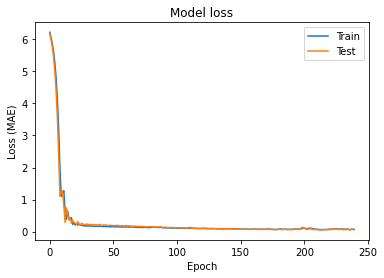


 Best Model's Parameters
{'learning_rate': 0.0005, 'n_hidden': 3, 'n_neurons': 450, 'build_fn': <function build_model at 0x7f7e52d54c10>}

 The mean absolute error (MAE)
1/1 [==============================] - 0s 28ms/step - loss: 0.0540
-0.05396534129977226

 The predicted values (Lattice constants)
1/1 [==============================] - 0s 70ms/step
[[6.053804  8.202547  5.7195916]
 [5.685912  7.8587174 5.561284 ]
 [5.5331125 7.6223245 5.381559 ]
 [5.7740006 8.072877  5.7593474]
 [5.5955563 7.7251863 5.462649 ]
 [5.5520134 7.5732355 5.308004 ]
 [5.549744  7.6771283 5.4365315]
 [5.574623  7.6555123 5.392587 ]
 [6.3184595 8.000311  5.2649827]
 [5.6143064 7.7353144 5.4617195]
 [5.6343536 7.8024015 5.5291724]
 [6.1476912 8.481462  5.9928384]
 [5.333041  7.38353   5.232565 ]
 [5.312951  7.324784  5.1748986]
 [5.8259983 8.130955  5.793334 ]
 [5.5072613 7.536712  5.295362 ]
 [5.685912  7.8587174 5.561284 ]
 [6.1568503 8.60226   6.1329145]
 [5.552518  7.5573897 5.2879257]
 [5.537159  7.63592

In [48]:
best_model = grid_result.best_estimator_

print ("\nHistory object\n")
best_model_history = best_model.fit(X_train, y_train, epochs=n_epochs,
              validation_data=(X_test, y_test),
              callbacks=[keras.callbacks.EarlyStopping(patience=tolerance_value)])
              
plt.figure()
plt.plot(best_model_history.history['loss'])
plt.plot(best_model_history.history['val_loss'])
plt.title("Model loss")
plt.ylabel("Loss (MAE)")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"])
plt.show()

print ("\n Best Model's Parameters")
print (best_model.get_params())
print ("\n The mean absolute error (MAE)")
print (best_model.score(X_test, y_test))
print ("\n The predicted values (Lattice constants)")
print (best_model.predict(X_test))

## Conclusion

In this notebook too I deployed the ANN and found was successful in predicting the lattice constants with the mean absolute error around -0.05. The GridSearch did not perform well I would have expected it do. However, it along a few techniques like feature scaling and the commented out linear model is next task in my schedule. 

This notebook could not be amongst the best performer. However, especially after building an ANN I am motivated to work further on Machine Learning domain. I have all the incentives to move ahead. 

## References

[1] Chonghe, Li, et al. "Prediction of lattice constant in perovskites of GdFeO3 structure." Journal of Physics and Chemistry of Solids 64.11 (2003): 2147-2156.

[2] Alade, Ibrahim Olanrewaju, Ismail Adewale Olumegbon, and Aliyu Bagudu. "Lattice constant prediction of A2XY6 cubic crystals (A= K, Cs, Rb, TI; X= tetravalent cation; Y= F, Cl, Br, I) using computational intelligence approach." Journal of Applied Physics 127.1 (2020): 015303.

[3] Jiang, L. Q., et al. "Prediction of lattice constant in cubic perovskites." Journal of Physics and Chemistry of Solids 67.7 (2006): 1531-1536.

[4] “Introduction to Machine Learning with Python, A Guide for Data Scientists", by Andreas C. Müller and Sarah Guido

[5] “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow", by Aurélien Géron

[6] "The Hundred-Page Machine Learning Book", by Andriy Burkov